#Creating data pipeline

In [ ]:

import tensorflow as tf

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import imgaug.augmenters as iaa
import numpy as np
from skimage.util import random_noise
import skimage


#dataset generation by adding various noise

In [ ]:
 class Dataset:
  
    
    def __init__(self, images_dir, file_names):
       
        self.ids = tf.data.Dataset.list_files(images_dir+"*.png")
        self.file_names = file_names
        self.te = []
        for f in self.ids:
          self.te.append(f)
     
        
    def __getitem__(self, i):
        
        image4 = tf.io.read_file(self.te[i])
        image = tf.image.decode_png(image4, channels=3, dtype=tf.uint8)
        image = tf.image.resize(image, [180,180])
        image = image/255.0
    
        image_noise = image       
      
        if (self.file_names != "X_trainffe"):
          
          a = np.random.uniform()

          if a<0.2:
              image = image
              image_noise = skimage.util.random_noise(image.numpy(), mode="gaussian")
          elif a<0.4:
              image = image
              image_noise = skimage.util.random_noise(image.numpy(), mode="localvar")
          elif a<0.6:
              image = image
              image_noise = skimage.util.random_noise(image.numpy(), mode="poisson")
          elif a<0.8:
              image = image
              image_noise = skimage.util.random_noise(image.numpy(), mode="s&p")
          else:
              image = image
              image_noise = skimage.util.random_noise(image.numpy(), mode="speckle")
            
        return image_noise,image
        
    def __len__(self):
        return len(self.ids)


class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
       
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)           
      
src_dir = 'data/final/'
test_path = 'data/Test/Set68/'
train_dataset = Dataset(src_dir,"X_train")
test_dataset  = Dataset(test_path,"X_test")
BATCH_SIZE=4
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 180, 180,3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 180, 180,3)

(4, 180, 180, 3)


#Following noise added using skimage module
*   gaussian
*   localvar
*   poisson
*   s&p
*   speckle


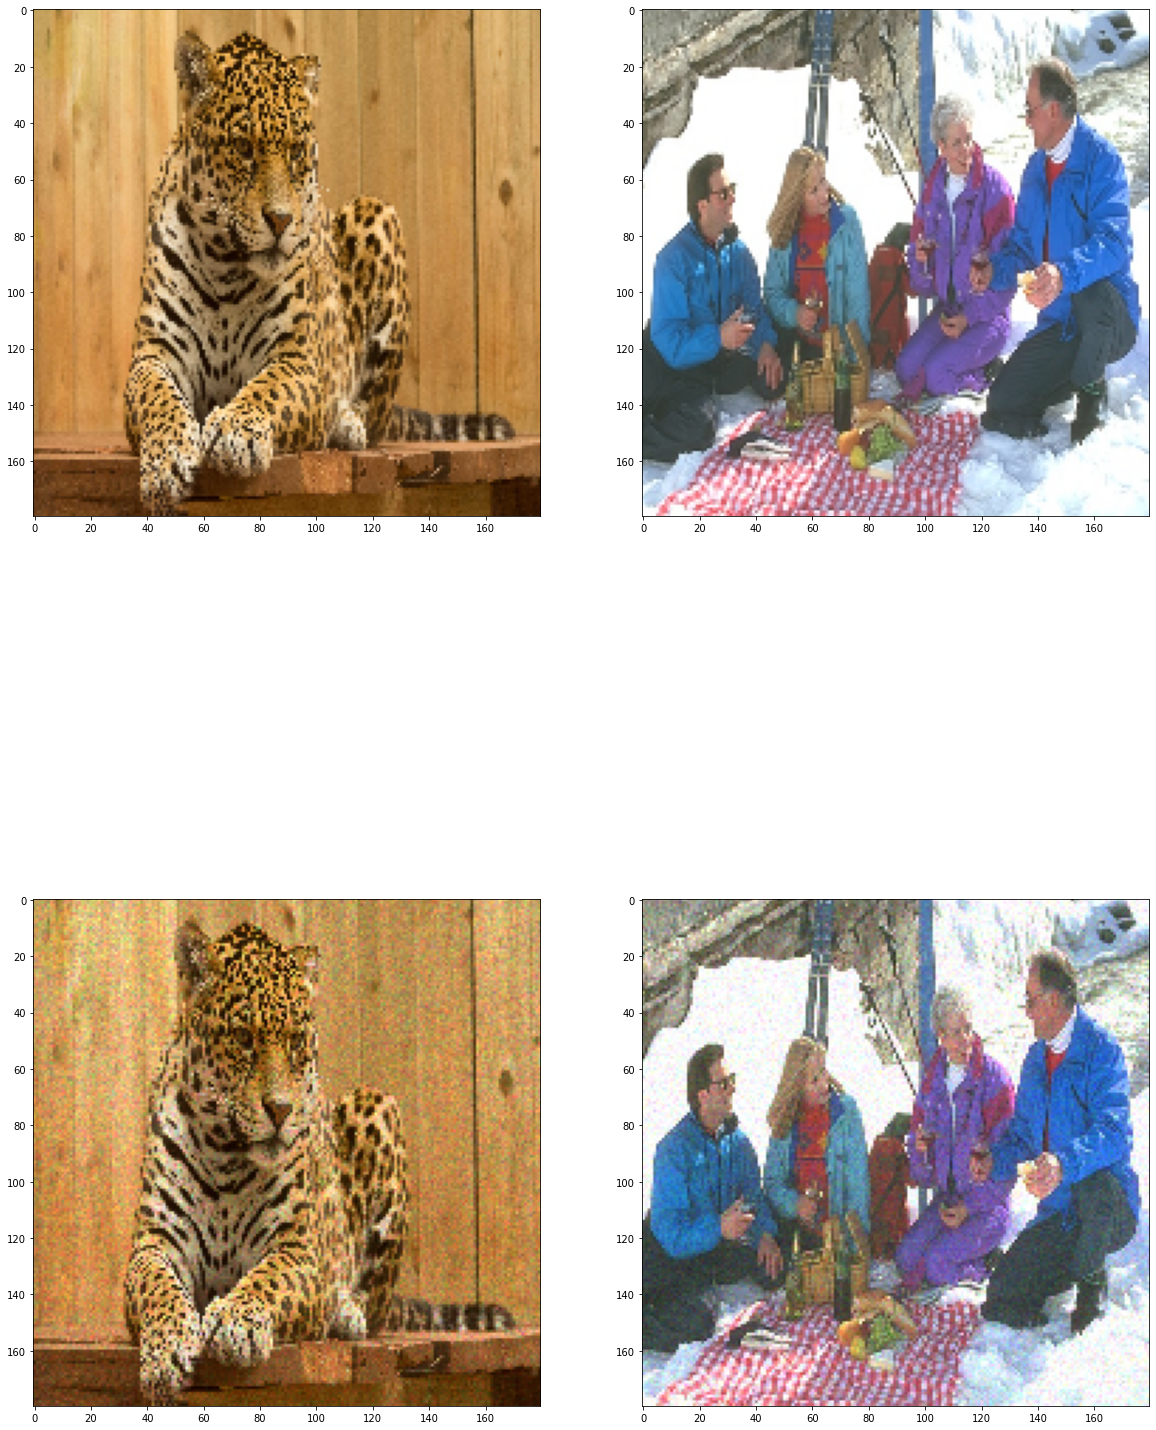

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,30))
plt.subplot(2,2,1)
plt.imshow(train_dataloader[0][1][2,:,:,:],cmap="gray")
plt.subplot(2,2,2)
plt.imshow(train_dataloader[0][1][3,:,:,:],cmap="gray")
plt.subplot(2,2,3)
plt.imshow(train_dataloader[0][0][2,:,:,:],cmap="gray")
plt.subplot(2,2,4)
plt.imshow(train_dataloader[0][0][3,:,:,:],cmap="gray")

# Custom Model Architecture 

In [ ]:

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers
import numpy as np
import keras
from keras import backend as K
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda,MaxPooling2D,LeakyReLU, Subtract,Dropout,BatchNormalization,ZeroPadding2D,Activation
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K
import tensorflow_probability as tfp
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')





inp = layers.Input(shape=(None,None,3))


a1 = Conv2D(256, (3, 3), activation='relu',strides=1,padding='same') (inp)


a4 = BatchNormalization(momentum=0.8) (a1)

a1 = Conv2D(128, (3, 3), activation='relu',strides=1,padding='same') (a4)

a3 = BatchNormalization(momentum=0.8) (a1)



a1 = Conv2D(128, (3, 3), activation='relu',strides=1,padding='same') (a3)

a1 = BatchNormalization(momentum=0.8) (a1)


a2 = tf.keras.layers.Concatenate()([a1, a3])

a1 = Conv2DTranspose(filters=64, kernel_size=(3, 3),activation='relu', strides=1, padding='same') (a2)
a1 = BatchNormalization(momentum=0.8) (a1)



a1 = Conv2DTranspose(filters=128, kernel_size=(3, 3), activation='relu',strides=1, padding='same') (a1)
a1 = BatchNormalization(momentum=0.8) (a1)


a1 = Conv2DTranspose(filters=256, kernel_size=(3, 3), activation='relu',strides=1, padding='same') (a2)
a1 = BatchNormalization(momentum=0.8) (a1)
a2 = tf.keras.layers.Concatenate()([a1, a4])


a1 = Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=1, padding='same') (a2)
a1 = BatchNormalization(momentum=0.8) (a1)
z = Activation('relu') (a1)
z = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(z)
#z=  Subtract()([out, inp])
z=  Subtract()([inp, z])
model = Model(inp, z, name='model')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, None, None, 2 7168        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, None, None, 2 1024        conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, None, None, 1 295040      batch_normalization_14[0][0]     
______________________________________________________________________________________________

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot_custom.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from datetime import datetime

callbacks = [ModelCheckpoint('./best_custom.h5', save_weights_only=True, save_best_only=True, \
                                      mode='min', monitor='loss'),
   
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=0.000001,patience=2),
    TensorBoard(log_dir="best_custom"),EarlyStopping(monitor='val_loss',patience=3)]

model.compile( optimizer=Adam(lr=0.00001),loss="mse")

history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=30,validation_data=test_dataloader,callbacks=callbacks,  )


In [ ]:

%load_ext tensorboard
#!rm -rf ./logs/ 

%tensorboard --logdir best_custom

#Testing the Model 

In [ ]:

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
#size of the model 
convert_bytes(get_file_size("best_custom.h5"), "MB")


File size: 4.04 Megabytes


In [ ]:

import logging
import argparse
import logging
import os, time, glob
import PIL.Image as Image
import numpy as np
import pandas as pd

from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.models import load_model
from keras.optimizers import Adam
from skimage.measure import compare_psnr, compare_ssim

def test(model):
    
    print('Start to test on {}'.format('data/Test/color'))
    
       psnr = []
    ssim = []
    file_list = glob.glob('{}/*.png'.format('data/Test/color'))
    for file in file_list:
     
        image4 = tf.io.read_file(file)
        img_clean = tf.image.decode_png(image4, channels=3, dtype=tf.uint8).numpy() / 255.0

        a = np.random.uniform()
        if a<0.2:
             
              img_test = skimage.util.random_noise(img_clean, mode="gaussian")
        elif a<0.4:
             
              img_test = skimage.util.random_noise(img_clean, mode="localvar")
        elif a<0.6:
             
              img_test = skimage.util.random_noise(img_clean, mode="poisson")
        elif a<0.8:
             
              img_test = skimage.util.random_noise(img_clean, mode="s&p")
        else:
              
              img_test = skimage.util.random_noise(img_clean, mode="speckle")

    
        img_test = img_test.astype('float32')
      
        x_test = img_test.reshape(1, img_test.shape[0], img_test.shape[1], 3) 
        y_predict = model.predict(x_test)
       
        img_out = y_predict.reshape(img_clean.shape)
        img_out = np.clip(img_out, 0, 1)
        psnr_noise, psnr_denoised = compare_psnr(img_clean, img_test), compare_psnr(img_clean, img_out)
        ssim_noise, ssim_denoised = compare_ssim(img_clean, img_test,multichannel=True), compare_ssim(img_clean, img_out,multichannel=True)
        psnr.append(psnr_denoised)
       
        ssim.append(ssim_denoised)
       
    
    psnr_avg = sum(psnr)/len(psnr)
    ssim_avg = sum(ssim)/len(ssim)
    name.append('Average')
    psnr.append(psnr_avg)
    ssim.append(ssim_avg)
    print('Average PSNR = {0:.2f}, SSIM = {1:.2f}'.format(psnr_avg, ssim_avg))
    
    pd.DataFrame({'name':np.array(name), 'psnr':np.array(psnr), 'ssim':np.array(ssim)}).to_csv(out_dir+'/metrics.csv', index=True)

test(model) 

In [ ]:
file_list = glob.glob('{}/*.png'.format('data/Test/Set68'))
for file in file_list[:5]:
        # read image
        image4 = tf.io.read_file(file)
        img_clean = tf.image.decode_png(image4, channels=3, dtype=tf.uint8).numpy()
        a = np.random.uniform()
        if a<0.2:
             
              img_test = skimage.util.random_noise(img_clean, mode="gaussian")
        elif a<0.4:
             
              img_test = skimage.util.random_noise(img_clean, mode="localvar")
        elif a<0.6:
             
              img_test = skimage.util.random_noise(img_clean, mode="poisson")
        elif a<0.8:
             
              img_test = skimage.util.random_noise(img_clean, mode="s&p")
        else:
              
              img_test = skimage.util.random_noise(img_clean, mode="speckle")

        img_test = img_test.astype('float32')
        # predict
        x_test = img_test.reshape(1, img_test.shape[0], img_test.shape[1], 3) 
        y_predict = model.predict(x_test)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(35,30))
        plt.subplot(1,3,1)
       # x_test[:,:,:] = np.clip(img_clean[:,:,:], 0, 1)
        plt.imshow(img_clean[:,:,:])
        
        plt.subplot(1,3,2)
        x_test[0,:,:,:] = np.clip(x_test[0,:,:,:], 0, 1)
        plt.imshow(x_test[0,:,:,:])

        plt.subplot(1,3,3)
        y_predict[0,:,:,:] = np.clip(y_predict[0,:,:,:], 0, 1)
        plt.imshow(y_predict[0,:,:,:])
        plt.show()
              

#Model Architecture edsr

In [ ]:
#https://github.com/krasserm/super-resolution/tree/master/model
from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda,subtract 
from tensorflow.python.keras.models import Model
from tensorflow.keras.models import Model as model
from keras.optimizers import Adam



def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    x_in = Input(shape=(None, None, 3))
    x = x_in #Lambda(normalize)(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3,activation = "sigmoid", padding='same')(x)

   # x = Lambda(denormalize)(x)
    return Model(x_in, x, name="edsr")


def res_block(x_in, filters, scaling):
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add() ([x_in, x])
    return x


def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x

In [ ]:

model = edsr(scale=1, num_res_blocks=8)
model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot_EDSR.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from datetime import datetime

callbacks = [ModelCheckpoint('./best_edsr1.h5', save_weights_only=True, save_best_only=True, \
                                      mode='min', monitor='loss'),
   
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=0.000001,patience=2),
    TensorBoard(log_dir="best_edsr1"),EarlyStopping(monitor='val_loss',patience=3)]

model.compile( optimizer=Adam(lr=0.0001),loss="mse")


history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=30,validation_data=test_dataloader,callbacks=callbacks,  )


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
417/417 [==============================] - 47s 109ms/step - loss: 0.0234 - val_loss: 0.0025
Epoch 2/30
417/417 [==============================] - 44s 106ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 3/30
417/417 [==============================] - 44s 106ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 4/30
417/417 [==============================] - 44s 106ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 5/30
417/417 [==============================] - 44s 106ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 6/30
417/417 [==============================] - 44s 107ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 7/30
417/417 [==============================] - 44s 106ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 8/30
417/417 [==============================] - 44s 106ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9/30
417/417 [==============================] - 45s 107ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/30
417/417 [==============================] - 44s 107ms/step - l

#Testing model

In [ ]:
convert_bytes(get_file_size("best_edsr1.h5"), "MB")


File size: 2.476 Megabytes


In [ ]:

import logging
import argparse
import logging
import os, time, glob
import PIL.Image as Image
import numpy as np
import pandas as pd

from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.models import load_model
from keras.optimizers import Adam
from skimage.measure import compare_psnr, compare_ssim

def test(model):
    
    print('Start to test on {}'.format('data/Test/color'))
    out_dir ='data/Test/color'.split('/')[-1] + '/'
    if not os.path.exists(out_dir):
            os.mkdir(out_dir)
            
    name = []
    psnr = []
    ssim = []
    file_list = glob.glob('{}/*.png'.format('data/Test/color'))
    for file in file_list:
      
        image4 = tf.io.read_file(file)
        img_clean = tf.image.decode_png(image4, channels=3, dtype=tf.uint8).numpy() / 255.0

        a = np.random.uniform()


        if a<0.2:
             
              img_test = skimage.util.random_noise(img_clean, mode="gaussian")
        elif a<0.4:
             
              img_test = skimage.util.random_noise(img_clean, mode="localvar")
        elif a<0.6:
             
              img_test = skimage.util.random_noise(img_clean, mode="poisson")
        elif a<0.8:
             
              img_test = skimage.util.random_noise(img_clean, mode="s&p")
        else:
              
              img_test = skimage.util.random_noise(img_clean, mode="speckle")

        img_test = img_test.astype('float32')
        x_test = img_test.reshape(1, img_test.shape[0], img_test.shape[1], 3) 
        y_predict = model.predict(x_test)
        
        img_out = y_predict.reshape(img_clean.shape)
        img_out = np.clip(img_out, 0, 1)
        psnr_noise, psnr_denoised = compare_psnr(img_clean, img_test), compare_psnr(img_clean, img_out)
        ssim_noise, ssim_denoised = compare_ssim(img_clean, img_test,multichannel=True), compare_ssim(img_clean, img_out,multichannel=True)
        psnr.append(psnr_denoised)
        print(psnr)
        ssim.append(ssim_denoised)
        filename = file.split('/')[-1].split('.')[0]    
        name.append(filename)
        img_test = Image.fromarray((img_test*255).astype('uint8'))
        img_test.save(out_dir+filename+'_sigma'+'{}_psnr{:.2f}.png'.format(25 ,psnr_noise))
        img_out = Image.fromarray((img_out*255).astype('uint8')) 
        img_out.save(out_dir+filename+'_psnr{:.2f}.png'.format(psnr_denoised))
    
    psnr_avg = sum(psnr)/len(psnr)
    ssim_avg = sum(ssim)/len(ssim)
    name.append('Average')
    psnr.append(psnr_avg)
    ssim.append(ssim_avg)
    print('Average PSNR = {0:.2f}, SSIM = {1:.2f}'.format(psnr_avg, ssim_avg))
    
    pd.DataFrame({'name':np.array(name), 'psnr':np.array(psnr), 'ssim':np.array(ssim)}).to_csv(out_dir+'/metrics.csv', index=True)

test(model) 

In [ ]:
#https://github.com/bhattbhavesh91/tflite-tutorials/blob/master/tflite-part-2.ipynb.

TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

tflite_model = tf_lite_converter.convert()

tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfs2j3jfq/assets


INFO:tensorflow:Assets written to: /tmp/tmpfs2j3jfq/assets


670736

In [ ]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "MB")


File size: 0.64 Megabytes


In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [1 1 1 3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 1 1 3]
Output Type: <class 'numpy.float32'>


In [ ]:

interpreter.resize_tensor_input(input_details[0]['index'], (1, 180, 180,3))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 180, 180,3))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 180 180   3]
Input Type: <class 'numpy.float32'>
Output Shape: [  1 180 180   3]
Output Type: <class 'numpy.float32'>


In [ ]:

import logging
import argparse
import logging
import os, time, glob
import PIL.Image as Image
import numpy as np
import pandas as pd

from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.models import load_model
from keras.optimizers import Adam
from skimage.measure import compare_psnr, compare_ssim

def test(model):
    
    print('Start to test on {}'.format('data/Test/color'))
    
            
    
    psnr = []
    ssim = []
    file_list = glob.glob('{}/*.png'.format('data/Test/color'))
    for file in file_list:
     
        image4 = tf.io.read_file(file)
        img_clean = tf.image.decode_png(image4, channels=3, dtype=tf.uint8).numpy() / 255.0

        a = np.random.uniform()


        if a<0.2:
             
              img_test = skimage.util.random_noise(img_clean, mode="gaussian")
        elif a<0.4:
             
              img_test = skimage.util.random_noise(img_clean, mode="localvar")
        elif a<0.6:
             
              img_test = skimage.util.random_noise(img_clean, mode="poisson")
        elif a<0.8:
             
              img_test = skimage.util.random_noise(img_clean, mode="s&p")
        else:
              
              img_test = skimage.util.random_noise(img_clean, mode="speckle")

      
        img_test = img_test.astype('float32')
        
        x_test = img_test.reshape(1, img_test.shape[0], img_test.shape[1], 3) 
    
        interpreter.set_tensor(input_details[0]['index'], x_test)
        interpreter.invoke()
        y_predict = interpreter.get_tensor(output_details[0]['index'])
       
        img_out = y_predict.reshape(img_clean.shape)
        img_out = np.clip(img_out, 0, 1)
        psnr_noise, psnr_denoised = compare_psnr(img_clean, img_test), compare_psnr(img_clean, img_out)
        ssim_noise, ssim_denoised = compare_ssim(img_clean, img_test,multichannel=True), compare_ssim(img_clean, img_out,multichannel=True)
        psnr.append(psnr_denoised)
        print(psnr)
        ssim.append(ssim_denoised)
       
    
    psnr_avg = sum(psnr)/len(psnr)
    ssim_avg = sum(ssim)/len(ssim)
    name.append('Average')
    psnr.append(psnr_avg)
    ssim.append(ssim_avg)
    print('Average PSNR = {0:.2f}, SSIM = {1:.2f}'.format(psnr_avg, ssim_avg))
    
    pd.DataFrame({'name':np.array(name), 'psnr':np.array(psnr), 'ssim':np.array(ssim)}).to_csv(out_dir+'/metrics.csv', index=True)

test(model) 

Start to test on data/Test/color


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/skimage/measure/simple_metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  return peak_signal_noise_ratio(im_true, im_test, data_range=data_range)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


[28.245628418013172]
[28.245628418013172, 28.290707872871312]
[28.245628418013172, 28.290707872871312, 34.902079777872224]
[28.245628418013172, 28.290707872871312, 34.902079777872224, 31.71920114945376]
[28.245628418013172, 28.290707872871312, 34.902079777872224, 31.71920114945376, 32.17859329095766]
[28.245628418013172, 28.290707872871312, 34.902079777872224, 31.71920114945376, 32.17859329095766, 33.572734520939235]
[28.245628418013172, 28.290707872871312, 34.902079777872224, 31.71920114945376, 32.17859329095766, 33.572734520939235, 35.29765248143875]
[28.245628418013172, 28.290707872871312, 34.902079777872224, 31.71920114945376, 32.17859329095766, 33.572734520939235, 35.29765248143875, 29.51621146903286]
[28.245628418013172, 28.290707872871312, 34.902079777872224, 31.71920114945376, 32.17859329095766, 33.572734520939235, 35.29765248143875, 29.51621146903286, 34.86435773167993]
[28.245628418013172, 28.290707872871312, 34.902079777872224, 31.71920114945376, 32.17859329095766, 33.572734

In [ ]:

from tensorflow import keras
model.load_weights('best_edsr1.h5')


In [ ]:
import glob
import numpy as np
import tensorflow as tf
import skimage
file_list = glob.glob('{}/*.png'.format('data/mixeddata/DIV2K_train_HR'))
for file in file_list[:5]:
        # read image
        image4 = tf.io.read_file(file)
        img_clean = tf.image.decode_png(image4, channels=3).numpy()
        a = np.random.uniform()
        if a<0.2:
             
              img_test = skimage.util.random_noise(img_clean, mode="gaussian")
        elif a<0.4:
             
              img_test = skimage.util.random_noise(img_clean, mode="localvar")
        elif a<0.6:
             
              img_test = skimage.util.random_noise(img_clean, mode="poisson")
        elif a<0.8:
             
              img_test = skimage.util.random_noise(img_clean, mode="s&p")
        else:
              
              img_test = skimage.util.random_noise(img_clean, mode="speckle")

        img_test = img_test.astype('float32')
        # predict
        x_test = img_test.reshape(1, img_test.shape[0], img_test.shape[1], 3) 
        y_predict = model.predict(x_test)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(35,45))
        plt.subplot(1,3,1)
       # x_test[:,:,:] = np.clip(img_clean[:,:,:], 0, 1)
        plt.imshow(img_clean[:,:,:])
        
        plt.subplot(1,3,2)
        x_test[0,:,:,:] = np.clip(x_test[0,:,:,:], 0, 1)
        plt.imshow(x_test[0,:,:,:])

        plt.subplot(1,3,3)
        y_predict[0,:,:,:] = np.clip(y_predict[0,:,:,:], 0, 1)
        plt.imshow(y_predict[0,:,:,:])
        plt.show()
              

#Model Architecture WDSR

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 10.6MB/s 


In [ ]:
import tensorflow_addons as tfa

from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda,subtract 
from tensorflow.python.keras.models import Model




def wdsr_a(scale, num_filters=32, num_res_blocks=8, res_block_expansion=4, res_block_scaling=None):
    return wdsr(scale, num_filters, num_res_blocks, res_block_expansion, res_block_scaling, res_block_a)


def wdsr_b(scale, num_filters=32, num_res_blocks=8, res_block_expansion=6, res_block_scaling=None):
    return wdsr(scale, num_filters, num_res_blocks, res_block_expansion, res_block_scaling, res_block_b)


def wdsr(scale, num_filters, num_res_blocks, res_block_expansion, res_block_scaling, res_block):
    x_in = Input(shape=(None, None, 3))
    x = x_in #Lambda(normalize)(x_in)

    # main branch
    m = conv2d_weightnorm(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        m = res_block(m, num_filters, res_block_expansion, kernel_size=3, scaling=res_block_scaling)
    m = conv2d_weightnorm(3, 3, padding='same', name=f'conv2d_main_scale_{scale}')(m)
   # m = Lambda(pixel_shuffle(scale))(m)

    # skip branch
    s = conv2d_weightnorm(3, 5, padding='same', name=f'conv2d_skip_scale_{scale}')(x)
   # s = Lambda(pixel_shuffle(scale))(s)

    x = Add()([m, s])
    #x = Lambda(denormalize)(x)

    return Model(x_in, x, name="wdsr")


def res_block_a(x_in, num_filters, expansion, kernel_size, scaling):
    x = conv2d_weightnorm(num_filters * expansion, kernel_size, padding='same', activation='relu')(x_in)
    x = conv2d_weightnorm(num_filters, kernel_size, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add() ([x_in, x])
    return x


def res_block_b(x_in, num_filters, expansion, kernel_size, scaling):
    linear = 0.8
    x = conv2d_weightnorm(num_filters * expansion, 1, padding='same', activation='relu')(x_in)
    x = conv2d_weightnorm(int(num_filters * linear), 1, padding='same')(x)
    x = conv2d_weightnorm(num_filters, kernel_size, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x


def conv2d_weightnorm(filters, kernel_size, padding='same', activation=None, **kwargs):
    return tfa.layers.WeightNormalization(Conv2D(filters, kernel_size, padding=padding, activation=activation, **kwargs), data_init=False)

In [ ]:

model = wdsr_a(scale=4, num_res_blocks=2)
model.summary()

Model: "wdsr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
weight_normalization (WeightNor (None, None, None, 3 929         input_2[0][0]                    
__________________________________________________________________________________________________
weight_normalization_1 (WeightN (None, None, None, 1 37121       weight_normalization[0][0]       
__________________________________________________________________________________________________
weight_normalization_2 (WeightN (None, None, None, 3 36929       weight_normalization_1[0][0]     
_______________________________________________________________________________________________

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot_WDSR.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from datetime import datetime
from keras.optimizers import Adam


callbacks = [ModelCheckpoint('./best_wdsr1.h5', save_weights_only=True, save_best_only=True, \
                                      mode='min', monitor='loss'),
   
       tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=0.000001,patience=2),

    TensorBoard(log_dir="best_wdsr1"),EarlyStopping(monitor='val_loss',patience=3)]

model.compile( optimizer=Adam(lr=0.0001),loss="mse")

history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=30,validation_data=test_dataloader,callbacks=callbacks,  )


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
417/417 [==============================] - 30s 68ms/step - loss: 0.0450 - val_loss: 0.0027
Epoch 2/30
417/417 [==============================] - 27s 65ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 3/30
417/417 [==============================] - 28s 67ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 4/30
417/417 [==============================] - 27s 65ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 5/30
417/417 [==============================] - 27s 66ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 6/30
417/417 [==============================] - 27s 64ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 7/30
417/417 [==============================] - 27s 64ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 8/30
417/417 [==============================] - 27s 64ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 9/30
417/417 [==============================] - 27s 64ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 10/30
417/417 [==============================] - 26s 64ms/step - loss: 0.002

In [ ]:
convert_bytes(get_file_size("best_wdsr1.h5"), "KB")


File size: 619.617 Kilobytes


In [ ]:

import logging
import argparse
import logging
import os, time, glob
import PIL.Image as Image
import numpy as np
import pandas as pd
#from keras import backend as K
#import tensorflow as tf
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.models import load_model
from keras.optimizers import Adam
from skimage.measure import compare_psnr, compare_ssim

def test(model):
    
    print('Start to test on {}'.format('data/Test/color'))

   
    psnr = []
    ssim = []
    file_list = glob.glob('{}/*.png'.format('data/Test/color'))
    for file in file_list:
       
        image4 = tf.io.read_file(file)
        img_clean = tf.image.decode_png(image4, channels=3, dtype=tf.uint8).numpy() / 255.0

        a = np.random.uniform()


        if a<0.2:
             
              img_test = skimage.util.random_noise(img_clean, mode="gaussian")
        elif a<0.4:
             
              img_test = skimage.util.random_noise(img_clean, mode="localvar")
        elif a<0.6:
             
              img_test = skimage.util.random_noise(img_clean, mode="poisson")
        elif a<0.8:
             
              img_test = skimage.util.random_noise(img_clean, mode="s&p")
        else:
              
              img_test = skimage.util.random_noise(img_clean, mode="speckle")

        img_test = img_test.astype('float32')
        x_test = img_test.reshape(1, img_test.shape[0], img_test.shape[1], 3) 
        y_predict = model.predict(x_test)
       
        img_out = y_predict.reshape(img_clean.shape)
        img_out = np.clip(img_out, 0, 1)
        psnr_noise, psnr_denoised = compare_psnr(img_clean, img_test), compare_psnr(img_clean, img_out)
        ssim_noise, ssim_denoised = compare_ssim(img_clean, img_test,multichannel=True), compare_ssim(img_clean, img_out,multichannel=True)
        psnr.append(psnr_denoised)
        print(psnr)
        ssim.append(ssim_denoised)
        
    
    psnr_avg = sum(psnr)/len(psnr)
    ssim_avg = sum(ssim)/len(ssim)
    name.append('Average')
    psnr.append(psnr_avg)
    ssim.append(ssim_avg)
    print('Average PSNR = {0:.2f}, SSIM = {1:.2f}'.format(psnr_avg, ssim_avg))
    
    pd.DataFrame({'name':np.array(name), 'psnr':np.array(psnr), 'ssim':np.array(ssim)}).to_csv(out_dir+'/metrics.csv', index=True)

test(model) 

Start to test on data/Test/color


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/skimage/measure/simple_metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  return peak_signal_noise_ratio(im_true, im_test, data_range=data_range)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


[30.73969773962609]
[30.73969773962609, 28.587540701133754]
[30.73969773962609, 28.587540701133754, 27.6085131555133]
[30.73969773962609, 28.587540701133754, 27.6085131555133, 34.87111556185876]
[30.73969773962609, 28.587540701133754, 27.6085131555133, 34.87111556185876, 27.322752377005482]
[30.73969773962609, 28.587540701133754, 27.6085131555133, 34.87111556185876, 27.322752377005482, 28.515796038390167]
[30.73969773962609, 28.587540701133754, 27.6085131555133, 34.87111556185876, 27.322752377005482, 28.515796038390167, 28.807022791759774]
[30.73969773962609, 28.587540701133754, 27.6085131555133, 34.87111556185876, 27.322752377005482, 28.515796038390167, 28.807022791759774, 34.86890199625502]
[30.73969773962609, 28.587540701133754, 27.6085131555133, 34.87111556185876, 27.322752377005482, 28.515796038390167, 28.807022791759774, 34.86890199625502, 30.300685408150535]
[30.73969773962609, 28.587540701133754, 27.6085131555133, 34.87111556185876, 27.322752377005482, 28.515796038390167, 28.80

In [ ]:

from tensorflow import keras
model.load_weights('best_wdsr1.h5')


In [ ]:
import glob
import numpy as np
import tensorflow as tf
import skimage
file_list = glob.glob('{}/*.png'.format('data/real'))
for file in file_list[:5]:
        # read image
        image4 = tf.io.read_file(file)
        img_clean = tf.image.decode_png(image4, channels=3).numpy()
        a = np.random.uniform()
        if a<0.2:
             
              img_test = skimage.util.random_noise(img_clean, mode="gaussian")
        elif a<0.4:
             
              img_test = skimage.util.random_noise(img_clean, mode="localvar")
        elif a<0.6:
             
              img_test = skimage.util.random_noise(img_clean, mode="poisson")
        elif a<0.8:
             
              img_test = skimage.util.random_noise(img_clean, mode="s&p")
        else:
              
              img_test = skimage.util.random_noise(img_clean, mode="speckle")

        # predict
        x_test = img_test.reshape(1, img_test.shape[0], img_test.shape[1], 3) 
        y_predict = model.predict(x_test)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(35,45))
      
        
        plt.subplot(1,2,1)
        x_test[0,:,:,:] = np.clip(x_test[0,:,:,:], 0, 1)
        plt.imshow(x_test[0,:,:,:])

        plt.subplot(1,2,2)
        y_predict[0,:,:,:] = np.clip(y_predict[0,:,:,:], 0, 1)
        plt.imshow(y_predict[0,:,:,:])
        plt.show()
              